# Imports

In [4]:
import numpy as np
import pandas as pd
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import wget
import tweepy
import json
import pprint as pp
from collections import defaultdict
from io import StringIO
import matplotlib.pyplot as plt
from PIL import Image
# from twitter_functions import *
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
from Twitter.twitter_functions import *

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
# This is needed to display the images.
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

from utils import label_map_util

from utils import visualization_utils as vis_util

In [20]:
tweets = check_for_hist("../Twitter/")

In [21]:
col = ['Hashtags','urls','media_url']
column_creator(tweets,col)

In [22]:
tweets

,Author,Id,Date,Text,Entities,Extended Entities,Hashtags,urls,media_url,image_name


In [23]:
get_media(tweets)

# Model preparation 

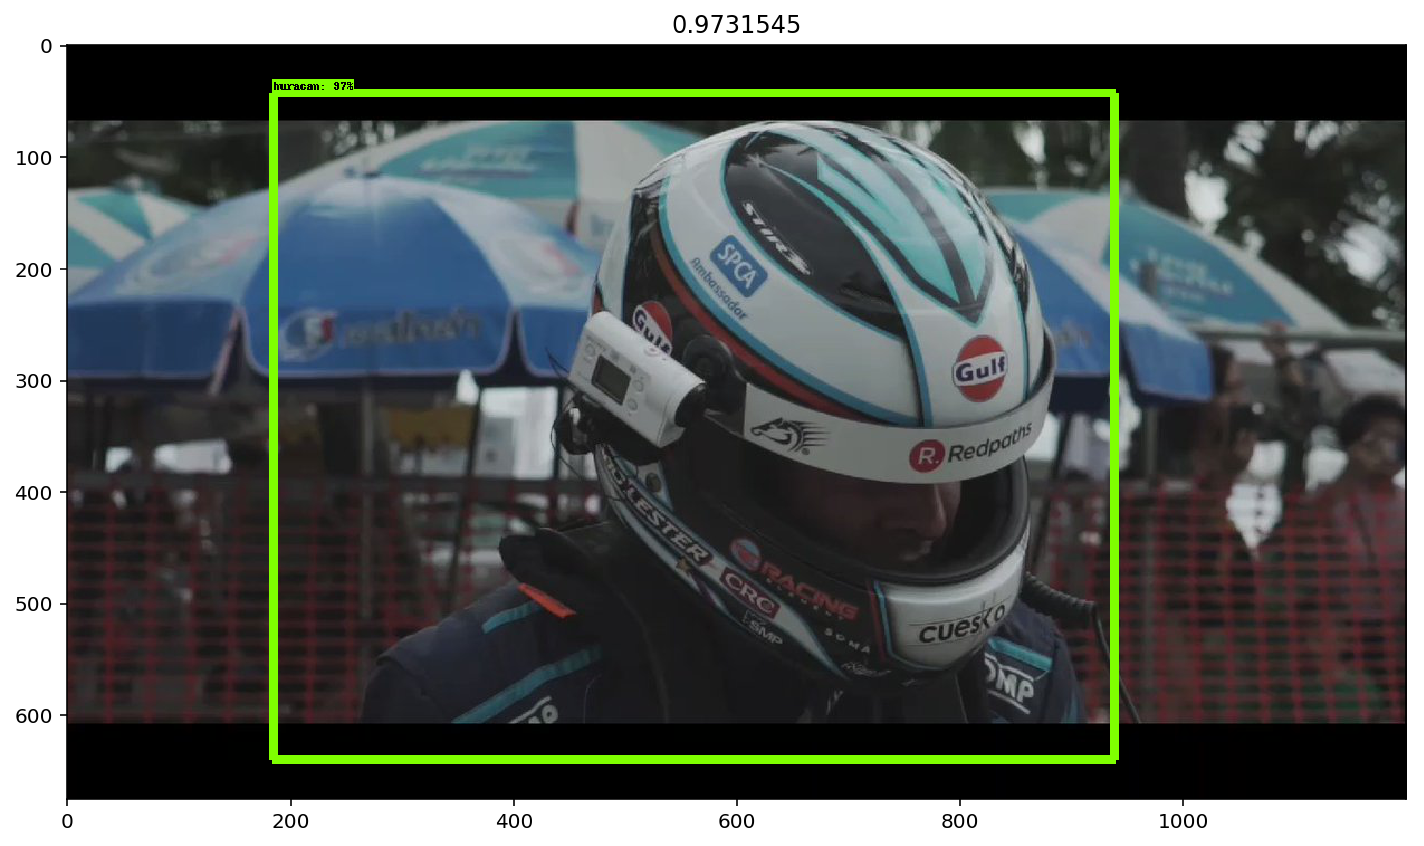

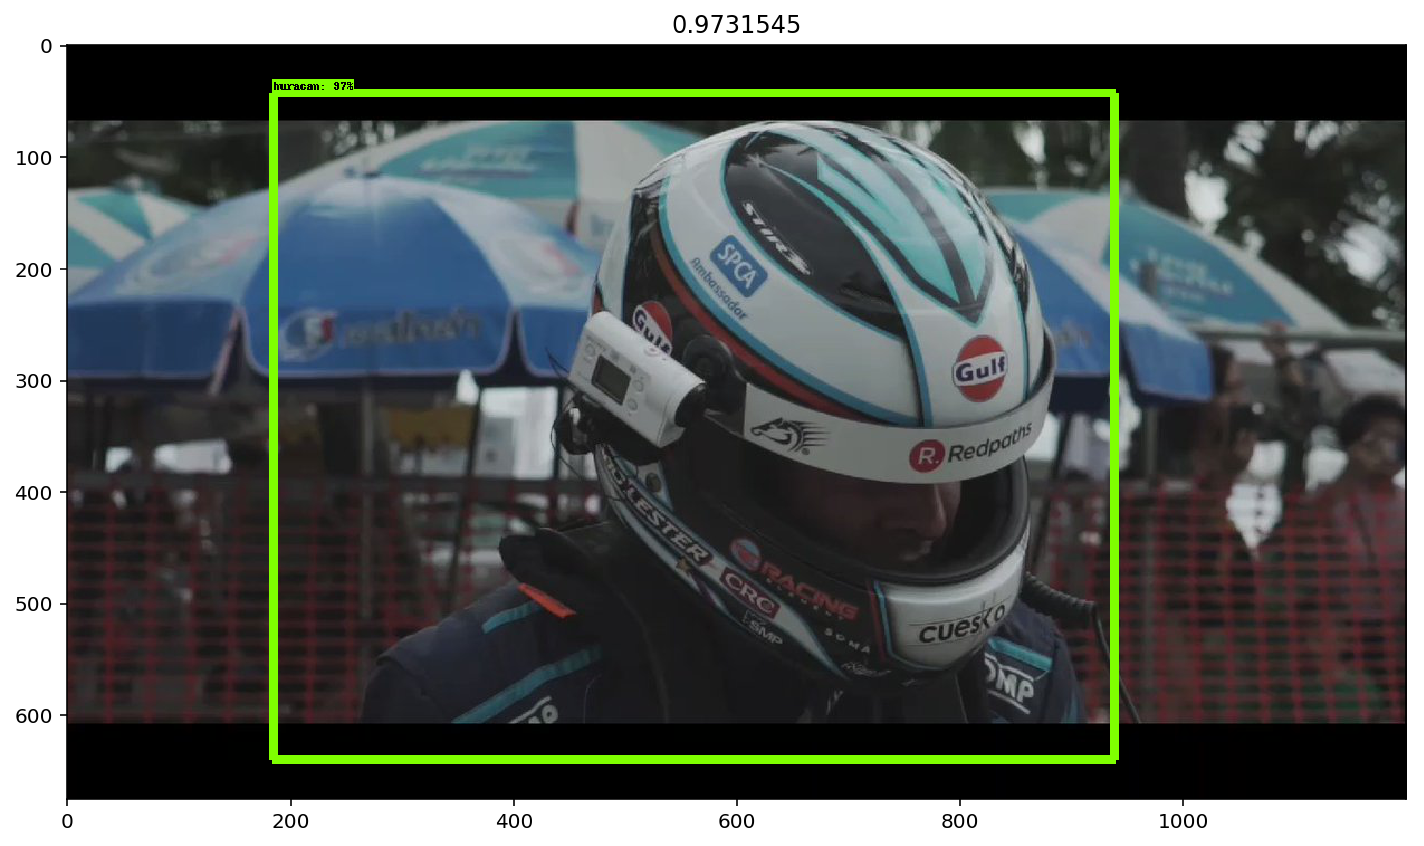

In [6]:
# What model to download.
MODEL_NAME = 'lambo_detection_graph/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + 'frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'lambo_detection.pbtxt')

NUM_CLASSES = 4

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

path = './test_images/'
photos = os.listdir(path=path)

PATH_TO_TEST_IMAGES_DIR = path
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}.jpg'.format(i[:-4])) for i in photos if i[-4:] == '.jpg']

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 12)

def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

to_tweet = {'to_tweet':[],
            'to_tweet_file':[],
            'image_score':[],
           }
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        object_dict = {}
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            output_dict = run_inference_for_single_image(image_np, detection_graph)
            # Visualization of the results of a detection.
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            threshold = 0.8

            (boxes, scores, classes, num) = sess.run(
                                                    [detection_boxes, 
                                                     detection_scores, 
                                                     detection_classes, 
                                                     num_detections],
                                                     feed_dict={image_tensor: image_np_expanded})
            vis_util.visualize_boxes_and_labels_on_image_array(image=image_np,
                                                               boxes = output_dict['detection_boxes'],
                                                               classes = output_dict['detection_classes'],
                                                               scores = output_dict['detection_scores'],
                                                               category_index = category_index,
                                                               instance_masks = output_dict.get('detection_masks'),
                                                               min_score_thresh = threshold,
                                                               use_normalized_coordinates=True,
                                                               line_thickness=8)     
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.title(scores[0][0])
            for index, value in enumerate(classes[0]):
                if scores[0, index] > threshold and (category_index.get(value)).get('name') == 'huracan':
                    to_tweet['to_tweet'].append(1)
                    to_tweet['to_tweet_file'].append(image_path)
                    to_tweet['image_score'].append(scores[0][0])
                    plt.figure(figsize=IMAGE_SIZE)
                    plt.imshow(image_np)
                    plt.title(scores[0][0])


In [25]:
to_tweet = pd.DataFrame(data=to_tweet)

In [26]:
pattern = '.+\/(\w.+)'
try:
    to_tweet['to_tweet_file'] = to_tweet['to_tweet_file'].str.extract(pattern)
except:
    pass

In [27]:
to_tweet

,image_score,to_tweet,to_tweet_file


In [10]:
tweets['post'] = tweets['image_name'].isin(to_tweet['to_tweet_file'])

In [11]:
tweets

,Author,Id,Date,Text,Entities,Extended Entities,Hashtags,urls,media_url,image_name,post


In [12]:
for index,image in tweets.iterrows():
    if image['post'] == True:
        status = "beep boop I'm an Image recognition Bot #Huracan #Lamborghini " + image['urls']
        print(status)
#         tweet_it = api.update_with_media(filename="../images/"+str(image['image_name']),status= status)
        
        

In [162]:
if 'already_seen.csv' not in os.listdir("../Twitter/"):
    print('creating new file')
    tweets.to_csv("../Twitter/already_seen.csv",index=False)
else:
    print('appending to csv')
    with open("../Twitter/already_seen.csv", 'a') as f:
        tweets.to_csv(f, mode='a', header=False,index=False)

appending to csv


In [188]:
for file in os.listdir("../images/"):
        if file[-4:] == '.jpg':
            os.remove("../images/" + file)